vgg + adam 모델 튜닝    - 오늘 5시 50분

모델 붙이기             - 내일 오전    ==> 디코딩 구현, //test data 출력//

ppt 자료, 발표 준비 //  - 내일 오전 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torchvision.transforms import RandomHorizontalFlip, RandomVerticalFlip
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA(GPU)를 사용합니다.")
else:
    device = torch.device("cpu")
    print("CUDA(GPU)를 사용할 수 없으므로, CPU를 사용합니다.")

CUDA(GPU)를 사용합니다.


In [3]:
# CIFAR10 데이터셋 로드 및 전처리
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((64, 64)),
    transforms.Normalize([0.6580, 0.6161, 0.5856], [0.2715, 0.2830, 0.2974]) # 알려진 CIFAR10의 평균과 표준편차
])
transform_horizontal_flip = transforms.Compose([
    RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Resize((64, 64)),
    transforms.Normalize([0.4913, 0.4821, 0.4465], [0.2470, 0.2434, 0.2615])
])

transform_vertical_flip = transforms.Compose([
    RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Resize((64, 64)),
    transforms.Normalize([0.4913, 0.4821, 0.4465], [0.2470, 0.2434, 0.2615])
])

# 데이터셋 불러오기
garbage_dataset = datasets.ImageFolder(root="./garbage_classification", transform=transform)
garbage_dataset_horizontal_flip = datasets.ImageFolder(root="./garbage_classification", transform=transform_horizontal_flip)
garbage_dataset_vertical_flip = datasets.ImageFolder(root="./garbage_classification", transform=transform_vertical_flip)

# 결합
from torch.utils.data import ConcatDataset
combined_dataset = ConcatDataset([garbage_dataset, garbage_dataset_horizontal_flip, garbage_dataset_vertical_flip])

total_size = len(combined_dataset)
# 훈련 세트의 비율 설정
train_ratio = 0.8

# 훈련 세트와 테스트 세트로 나누기
train_size = int(train_ratio * total_size)
test_size = total_size - train_size
train_dataset, test_dataset = torch.utils.data.random_split(combined_dataset, [train_size, test_size])

# 훈련과 테스트 데이터로더 생성
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True)
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False)

In [4]:
### basic ###

class myVggNet(nn.Module):
    def __init__(self):
        super(myVggNet, self).__init__()
        # vgg16 모델 로드
        self.vggnet = models.vgg19()
        # 출력 레이어를 클래스 수에 맞게 조정
        num_ftrs = self.vggnet.classifier[6].in_features
        self.vggnet.classifier[6].in_features = nn.Linear(num_ftrs, 12)

    def forward(self, x):
        return self.vggnet(x)

In [9]:
class myVggNet(nn.Module):
    def __init__(self):
        super(myVggNet, self).__init__()
        # vgg16 모델 로드
        self.vggnet = models.vgg19()
        # 출력 레이어를 클래스 수에 맞게 조정
        num_ftrs = self.vggnet.classifier[6].in_features
        self.vggnet.classifier[6].in_features = nn.Linear(num_ftrs, 12)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.vggnet.features(x)
        x = self.vggnet.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.vggnet.classifier(x)
        x = self.dropout(x)
        return x

In [5]:
# 손실과 정확도를 저장하기 위한 리스트 초기화
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [6]:
model = myVggNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [7]:
# 훈련 함수    
def train(model, train_loader, optimizer, epoch):

    
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for data, target in train_loader:
        if torch.cuda.is_available():
            data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

    # 예측값 계산(가장 높은 값을 가진 인덱스)
    _, predicted = torch.max(output.data, 1)
    total += target.size(0)
    # 올바르게 예측된 샘플의 수 업데이트
    correct += (predicted == target).sum().item()

    # 평균 훈련 손실 계산
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    print(f'Epoch {epoch}, Training loss: {train_loss:.4f}')
    accuracy = 100. * correct / total
    train_accuracies.append(accuracy)

In [8]:
# 테스트 함수
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            if torch.cuda.is_available():
                data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader)
    accuracy = 100. * correct / len(test_loader.dataset)
    test_losses.append(test_loss)
    test_accuracies.append(accuracy)
    print(f'Test loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%')

In [9]:
for epoch in range(1, 21):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)

c:\Users\lma00\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 1, Training loss: 2.1661
Test loss: 1.4544, Accuracy: 51.11%
Epoch 2, Training loss: 1.2722
Test loss: 1.1122, Accuracy: 62.38%
Epoch 3, Training loss: 0.9713
Test loss: 0.8450, Accuracy: 72.06%
Epoch 4, Training loss: 0.8355
Test loss: 0.7486, Accuracy: 75.82%
Epoch 5, Training loss: 0.7146
Test loss: 0.6919, Accuracy: 76.86%
Epoch 6, Training loss: 0.6255
Test loss: 0.6606, Accuracy: 78.90%
Epoch 7, Training loss: 0.5404
Test loss: 0.5651, Accuracy: 81.77%
Epoch 8, Training loss: 0.4753
Test loss: 0.5430, Accuracy: 82.90%
Epoch 9, Training loss: 0.3871
Test loss: 0.4997, Accuracy: 84.05%
Epoch 10, Training loss: 0.3325
Test loss: 0.4383, Accuracy: 85.98%
Epoch 11, Training loss: 0.2828
Test loss: 0.4619, Accuracy: 86.08%
Epoch 12, Training loss: 0.2424
Test loss: 0.3660, Accuracy: 89.15%
Epoch 13, Training loss: 0.2019
Test loss: 0.3739, Accuracy: 88.61%
Epoch 14, Training loss: 0.1705
Test loss: 0.4118, Accuracy: 88.57%
Epoch 15, Training loss: 0.1404
Test loss: 0.3282, Accura

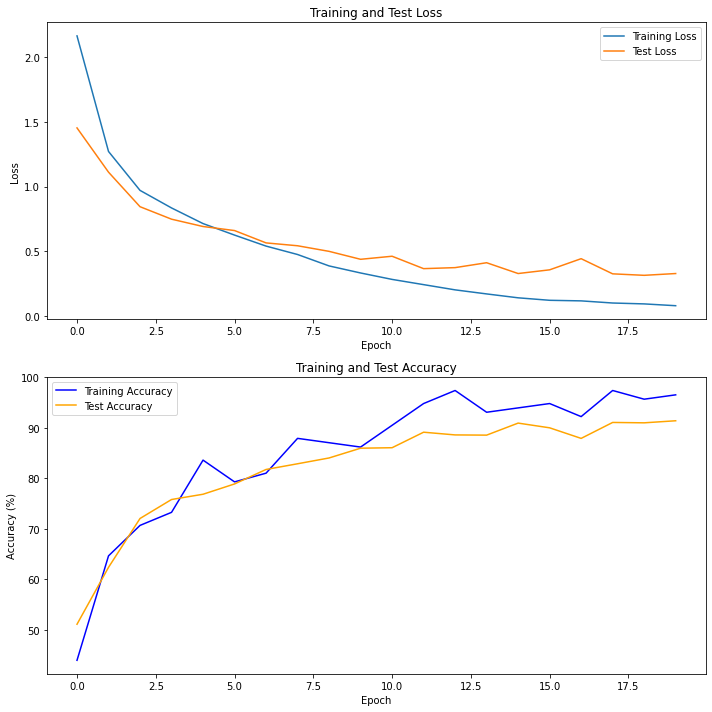

In [10]:
import matplotlib.pyplot as plt

# 손실 및 정확도 시각화
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(train_losses, label='Training Loss')
axs[0].plot(test_losses, label='Test Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].set_title('Training and Test Loss')

axs[1].plot(train_accuracies, label='Training Accuracy', color='blue')
axs[1].plot(test_accuracies, label='Test Accuracy', color='orange')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy (%)')
axs[1].legend()
axs[1].set_title('Training and Test Accuracy')

plt.tight_layout()
plt.show()

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torchvision.transforms import RandomHorizontalFlip, RandomVerticalFlip
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA(GPU)를 사용합니다.")
else:
    device = torch.device("cpu")
    print("CUDA(GPU)를 사용할 수 없으므로, CPU를 사용합니다.")

CUDA(GPU)를 사용합니다.


In [3]:
# CIFAR10 데이터셋 로드 및 전처리
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((64, 64)),
    transforms.Normalize([0.6580, 0.6161, 0.5856], [0.2715, 0.2830, 0.2974]) # 알려진 CIFAR10의 평균과 표준편차
])
transform_horizontal_flip = transforms.Compose([
    RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Resize((64, 64)),
    transforms.Normalize([0.4913, 0.4821, 0.4465], [0.2470, 0.2434, 0.2615])
])

transform_vertical_flip = transforms.Compose([
    RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Resize((64, 64)),
    transforms.Normalize([0.4913, 0.4821, 0.4465], [0.2470, 0.2434, 0.2615])
])
transform_horizontal_vertical_flip = transforms.Compose([
    RandomHorizontalFlip(),
    RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Resize((64, 64)),
    transforms.Normalize([0.4913, 0.4821, 0.4465], [0.2470, 0.2434, 0.2615])
])


In [4]:

# 데이터셋 불러오기
garbage_dataset = datasets.ImageFolder(root="./garbage_classification", transform=transform)
garbage_dataset_horizontal_flip = datasets.ImageFolder(root="./garbage_classification", transform=transform_horizontal_flip)
garbage_dataset_vertical_flip = datasets.ImageFolder(root="./garbage_classification", transform=transform_vertical_flip)
garbage_dataset_horizontal_vertical_flip = datasets.ImageFolder(root="./garbage_classification", transform=transform_horizontal_vertical_flip)

# 결합
from torch.utils.data import ConcatDataset
combined_dataset = ConcatDataset([garbage_dataset, garbage_dataset_horizontal_flip, garbage_dataset_vertical_flip, garbage_dataset_horizontal_vertical_flip])


In [5]:
import random
import torch.utils.data

def classwise_train_test_split(dataset, train_ratio=0.8):
    # 클래스별로 인덱스를 저장할 딕셔너리 생성
    class_indices = {}
    for i in range(len(dataset)):
        _, label = dataset[i]
        if label not in class_indices:
            class_indices[label] = []
        class_indices[label].append(i)
    
    # 클래스별로 train과 test를 나누기 위한 인덱스를 저장할 딕셔너리 생성
    train_indices = {}
    test_indices = {}
    for label, indices in class_indices.items():
        n_train = int(len(indices) * train_ratio)
        train_indices[label] = random.sample(indices, n_train)
        test_indices[label] = list(set(indices) - set(train_indices[label]))
    
    # train과 test 데이터셋 생성
    train_data = []
    test_data = []
    for label, indices in train_indices.items():
        train_data.extend([(dataset[i][0], label) for i in indices])
    for label, indices in test_indices.items():
        test_data.extend([(dataset[i][0], label) for i in indices])
    
    # DataLoader 생성
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=256, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=128, shuffle=False)
    
    return train_loader, test_loader

# 위에서 정의한 함수를 사용하여 train_loader와 test_loader 생성
train_loader, test_loader = classwise_train_test_split(combined_dataset)


c:\Users\lma00\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [ ]:

total_size = len(combined_dataset)
# 훈련 세트의 비율 설정
train_ratio = 0.8

# 훈련 세트와 테스트 세트로 나누기
train_size = int(train_ratio * total_size)
test_size = total_size - train_size
train_dataset, test_dataset = torch.utils.data.random_split(combined_dataset, [train_size, test_size])

# 훈련과 테스트 데이터로더 생성
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True)
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False)

In [6]:
### basic ###

class myVggNet(nn.Module):
    def __init__(self):
        super(myVggNet, self).__init__()
        # vgg16 모델 로드
        self.vggnet = models.vgg19()
        # 출력 레이어를 클래스 수에 맞게 조정
        num_ftrs = self.vggnet.classifier[6].in_features
        self.vggnet.classifier[6].in_features = nn.Linear(num_ftrs, 12)

    def forward(self, x):
        return self.vggnet(x)

In [45]:
class myVggNet(nn.Module):
    def __init__(self):
        super(myVggNet, self).__init__()
        # vgg16 모델 로드
        self.vggnet = models.vgg19()
        # 출력 레이어를 클래스 수에 맞게 조정
        num_ftrs = self.vggnet.classifier[6].in_features
        self.vggnet.classifier[6].in_features = nn.Linear(num_ftrs, 12)
        self.dropout = nn.Dropout(0.3)

        self.input_size = self._get_input_size()

        # Classifier 부분 수정
        self.classifier = nn.Sequential(
            nn.Linear(self.input_size, 4096),  # 수정 필요
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 12),
        )
    def _get_input_size(self):
        # 랜덤 입력 데이터를 생성
        x = torch.randn(1, 3, 224, 224)
        x = self.vggnet.features(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = torch.flatten(x, 1)
        return x.size(1)

    def forward(self, x):
        x = self.vggnet.features(x)
        # x = self.vggnet.maxpool(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = torch.flatten(x, 1)
        x = self.vggnet.classifier(x)
        x = self.dropout(x)
        return x

In [4]:
class myVggNet(nn.Module):
    def __init__(self):
        super(myVggNet, self).__init__()
        # vgg16 모델 로드
        self.vggnet = models.vgg19()
        # 출력 레이어를 클래스 수에 맞게 조정
        num_ftrs = self.vggnet.classifier[6].in_features
        self.vggnet.classifier[6].in_features = nn.Linear(num_ftrs, 12)
        # self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.vggnet.features(x)
        # x = self.maxpool(x)
        # x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = torch.flatten(x, 1)
        x = self.vggnet.classifier(x)
        x = self.dropout(x)
        return x

In [7]:
# 손실과 정확도를 저장하기 위한 리스트 초기화
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [8]:
model = myVggNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0005)

In [9]:
# 훈련 함수    
def train(model, train_loader, optimizer, epoch):

    
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for data, target in train_loader:
        if torch.cuda.is_available():
            data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

    # 예측값 계산(가장 높은 값을 가진 인덱스)
    _, predicted = torch.max(output.data, 1)
    total += target.size(0)
    # 올바르게 예측된 샘플의 수 업데이트
    correct += (predicted == target).sum().item()

    # 평균 훈련 손실 계산
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    print(f'Epoch {epoch}, Training loss: {train_loss:.4f}')
    accuracy = 100. * correct / total
    train_accuracies.append(accuracy)

In [10]:
# 테스트 함수
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            if torch.cuda.is_available():
                data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader)
    accuracy = 100. * correct / len(test_loader.dataset)
    test_losses.append(test_loss)
    test_accuracies.append(accuracy)
    print(f'Test loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%')

In [11]:
for epoch in range(1, 21):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)

KeyboardInterrupt: 

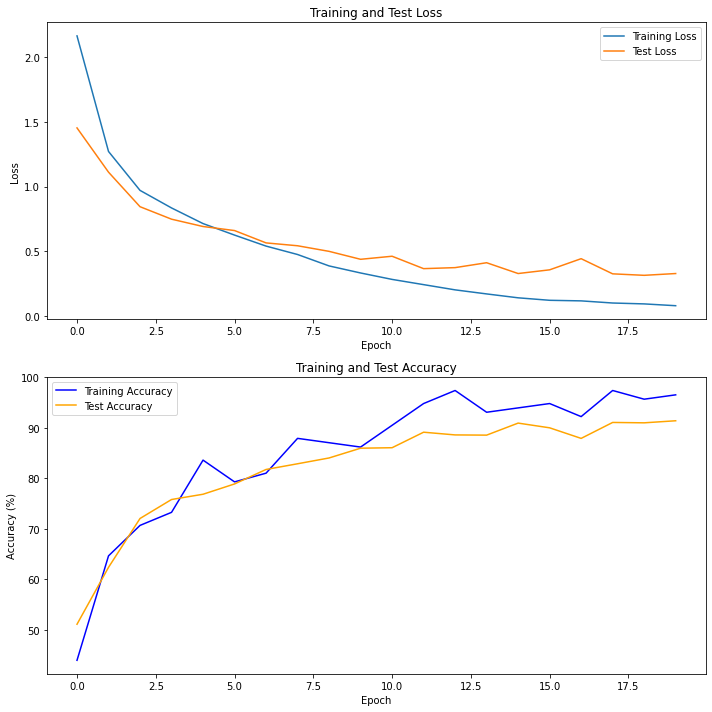

In [ ]:
import matplotlib.pyplot as plt

# 손실 및 정확도 시각화
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(train_losses, label='Training Loss')
axs[0].plot(test_losses, label='Test Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].set_title('Training and Test Loss')

axs[1].plot(train_accuracies, label='Training Accuracy', color='blue')
axs[1].plot(test_accuracies, label='Test Accuracy', color='orange')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy (%)')
axs[1].legend()
axs[1].set_title('Training and Test Accuracy')

plt.tight_layout()
plt.show()

* 증강
* L2 규제
* dropout 수치 조정
* batch 사이즈 조정
* max pooling
* 커널, stride 조정
* 